In [1]:
# external libraries
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# internal libraries
import logging

# initilize logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
def fixed_point(Gfun, x, maxit, rtol, atol, output=True):

	prev_x = None
	for i in range(maxit):
		next_x = Gfun(x)

		if output:
			output_string = " n = %s, \tx_{n} = %g," % (i, next_x)
			if prev_x is not None:
				# |e_{n}|/|e_{n-1}| ~= |x_{n}-x_{n-1}|/|x_{n-1}-x_{n-2}|
				approximate_error_string = " \t|e_{n}|/|e_{n-1}| ~= %s"
				approximate_error = abs(next_x - x)/abs(x-prev_x)
				output_string += approximate_error_string % approximate_error
			logger.info(output_string)

		if (abs(x - next_x) < atol + rtol*next_x): 
			return next_x

		prev_x = x
		x = next_x

	# log failure to converge
	logger.info("\n\nFailure to converge in fixed_point.\n\n")

	return x
	

In [3]:
def get_fp_iteration_display_points(Gfun, x0, atol, rtol, maxits):
	# first iteration: xaxis (x0, 0) -> y=g (x0, Gfun(x0)) -> y=x (Gfun(x0), Gfun(x0)) -> 
	xs = [x0]
	ys = [0]

	guesses = [x0]

	for i in range(maxits):
		#y=g (yk, Gfun(xk))
		xk0 = xs[-1]
		yk0 = Gfun(xk0)

		#y=x (Gfun(xk), Gfun(xk))
		xk1 = Gfun(xk0)
		yk1 = Gfun(xk0)

		#y=0, x=xk+1 (Gfun(xk), 0)
		xk2 = Gfun(xk0)
		yk2 = 0

		xs += [xk0, xk1, xk2]
		ys += [yk0, yk1, yk2]

		guesses += [xk2]

		s = xs[-1] - Gfun(xs[-1])
		if (abs(s) < atol + rtol*s):
			return xs, ys, guesses, i, True # return number of iterations and wether or not there was convergence

	return xs, ys, guesses, i, False #  return number of iterations and wether or not there was convergence


In [4]:
def aitken_fp(Gfun, x, maxit, rtol, atol, output=True):

	# for error convergence output
	prev_x = None
	cur_x = x
	next_x = None

	for i in range(maxit):

		# for error convergence output
		cur_x = x

		x0 = x
		x1 = Gfun(x0)
		x2 = Gfun(x1)

		denominator = (x2 - 2*x1 + x0)

		if denominator != 0:
			r = (x2*x0 - x1*x1)/denominator
			s = r-x
			x = r

			# for error convergence output
			next_x = x

		else:
			s = abs(x0 - x)
			x = x2

			# for error convergence output
			next_x = x

		if output:
			output_string = " n = %s, \tx_{n} = %g," % (i, next_x)
			if prev_x is not None:
				# |e_{n}|/|e_{n-1}| ~= |x_{n}-x_{n-1}|/|x_{n-1}-x_{n-2}|
				approximate_error_string = " \t|e_{n}|/|e_{n-1}| ~= %s"
				approximate_error = abs(next_x - cur_x)/abs(cur_x-prev_x)
				output_string += approximate_error_string % approximate_error
			logger.info(output_string)

			# for error convergence output
			prev_x = x0


		if (abs(s) < atol + rtol*s):
			return x

	# log failure to converge
	logger.info("\n\nFailure to converge in aitken_fp.\n\n")

	return x

In [5]:
def get_aa_iteration_display_points(Gfun, x0, atol, rtol, maxits):

	xs = [x0]
	ys = [0]
	guesses = [x0]

	for i in range(maxits):
		x = xs[-1]
		x0 = xs[-1]

		# aitken acceleration
		x1 = Gfun(x0)
		x2 = Gfun(x1)

		denominator = (x2 - 2*x1 + x0)

		if denominator != 0:
			r = (x2*x0 - x1*x1)/denominator
			s = r-x
			x = r
		else:
			s = abs(x0 - x)
			x = x2

		xs += [x, x]
		ys += [0, Gfun(x)]
		guesses += [x]

		if (abs(s) < atol + rtol*s):
			return xs, ys, guesses, i+1, True  # return number of iterations and wether or not there was convergence

	return xs, ys, guesses, i+1, False  # return number of iterations and wether or not there was convergence



In [6]:
def plot_function(Gfun, latex, x0, domain, num_points, axsi, title):

		x = np.linspace(domain[0],domain[1],num_points)
		y = x # compute data points for plot y = x
		gx = Gfun(x) # compute y data points for plot y = g(x)
		

		# create plot for this function
		axsi.plot( x, gx, 'r', label=latex)     # y = g(x) in red
		axsi.plot( x, y, 'b', label='x' ) 	   # y = x in blue

		axsi.set_title(title, fontsize=8)

		axsi.grid(True, which='both')

		axsi.axhline(y=0, color='k')
		axsi.axvline(x=0, color='k')

		axsi.set_aspect('equal') # equal
		axsi.set_ylim([domain[0],domain[1]]) # set y lim

		axsi.legend(loc=9, bbox_to_anchor=(0.5, -0.2))


In [7]:
def plot_iterations(axsi, xs, ys, guesses, its, convergence):

	axsi.plot(xs, ys, color='m', marker=None, linestyle='dashed', linewidth=0.5)

	text = "Convergence (iter:%s)" % its
	text_color = "g"
	if not convergence:
		text = "No Convergence (iter:%s)" % its
		text_color = "r"

	ylim = axsi.get_ylim()
	axsi.text(0, ylim[0],text, color=text_color, fontsize=8, ha='center', va='bottom', alpha=0.8)

	cm = plt.get_cmap("hot") 
	cNorm = colors.Normalize(vmin=0, vmax=len(guesses))
	scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
	for idx,g in enumerate(guesses):
		colorVal = scalarMap.to_rgba(idx)
		alpha=1 #1/(idx+1)
		markersize= 20/(idx+1)
		axsi.plot(g,0, marker='x', color=colorVal, alpha=alpha,markersize=markersize)

	cNorm = colors.Normalize(vmin=0, vmax=len(xs))
	scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
	for idx in range(len(xs)):
		colorVal = scalarMap.to_rgba(idx)
		alpha=0.75 #1/(idx+1)
		markersize= 10/(idx+1)
		axsi.plot(xs[idx],ys[idx], marker='.', color=colorVal, alpha=alpha, markersize=markersize)



In [8]:

def analysis_plot(fixed_point_functions, order, domain, atol, rtol, maxits, num_points=300):

	# setting up figure
	num_functions = len(fixed_point_functions)

	fig, axs = plt.subplots(2, num_functions, figsize=(15, 7), facecolor='w', edgecolor='k')
	fig.subplots_adjust(hspace = .5, wspace=.7, top=0.94, bottom=0.18)
	axs = axs.ravel()

	for i, name in enumerate(order):

		Gfun = fixed_point_functions[name]['method']
		latex = fixed_point_functions[name]['latex']
		x0 = fixed_point_functions[name]['initial guess']

		# plot non aitken accelerated fixed point iterations
		title = "%s). Without aitken acceleration" % name
		axsi = axs[i]
		plot_function(Gfun, latex, x0, domain, num_points, axsi, title)

		# plot aitken accelerated fixed point itterations
		title = "%s). With aitken acceleration" % name
		axsi = axs[i+num_functions]
		plot_function(Gfun, latex, x0, domain, num_points, axsi, title)


		#
		#	Display iterations without aitken acceleration
		#

		# display fixed point finding iterations
		xs, ys, guesses, its, convergence = get_fp_iteration_display_points(Gfun, x0, atol, rtol, maxits)	
		plot_iterations(axs[i], xs, ys, guesses, its, convergence)


		#
		#	Display iterations with aitken acceleration
		#

		# display fixed point finding iterations
		xs, ys, guesses, its, convergence = get_aa_iteration_display_points(Gfun, x0, atol, rtol, maxits)	
		plot_iterations(axs[i+num_functions], xs, ys, guesses, its, convergence)


	plt.show()

INFO:__main__:

SHOW_OUTPUT set to True.




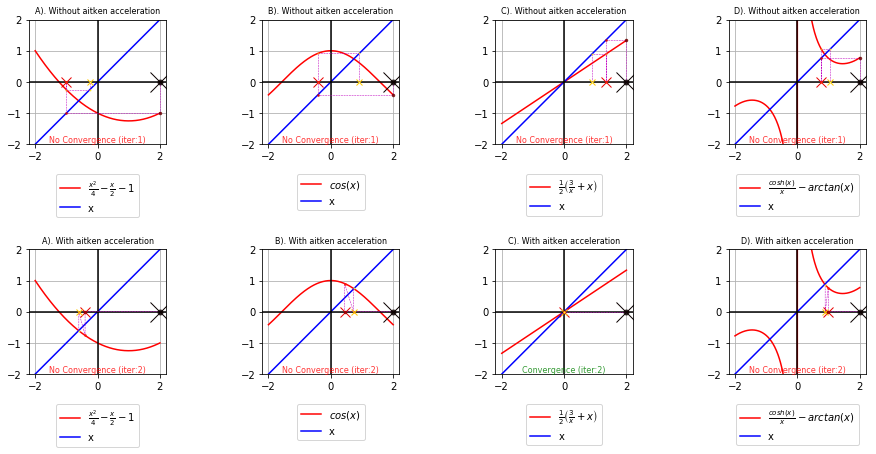

INFO:__main__:

	Running fixed point iterations WITHOUT aitken acceleration on problem A.

	Function A.

INFO:__main__: n = 0, 	x_{n} = -1,
INFO:__main__: n = 1, 	x_{n} = -0.25, 	|e_{n}|/|e_{n-1}| ~= 0.25
INFO:__main__:

Failure to converge in fixed_point.


INFO:__main__:

[Method 2]: 
Final fixed point target error WITHOUT using acceleration acceleration.
             
	Function name: A, 

		 |Gfun(x) - x| = 0.609375.

INFO:__main__:

	Running fixed point iterations WITH aitken acceleration on problem A.

	Function A.

INFO:__main__: n = 0, 	x_{n} = -0.4,
INFO:__main__: n = 1, 	x_{n} = -0.601117, 	|e_{n}|/|e_{n-1}| ~= 0.08379888268156425
INFO:__main__:

Failure to converge in aitken_fp.


INFO:__main__:

[Method 2]: 
Final fixed point target error using acceleration acceleration.
             
	Function name: A, 

		 |Gfun(x) - x| = 0.007988514715520645.

INFO:__main__:

	Running fixed point iterations WITHOUT aitken acceleration on problem B.

	Function B.

INFO:__main__: n = 0, 	x_

In [13]:
SHOW_OUTPUT = True

# log SHOW_OUTPUT value
logger.info("\n\nSHOW_OUTPUT set to %s.\n\n" % SHOW_OUTPUT)

# test functions:
fixed_point_functions = {
    'A' : {
            'method' : lambda x: (x**2)/4 -x/2 -1,
            'initial guess' : 2,
            'latex' : r"$\frac{x^{2}}{4} -\frac{x}{2} -1$",
            'approx_solution' : -0.605551,
            'analysis' : ""
            },
    'B' : {
            'method' : lambda x:  np.cos(x),
            'initial guess' : 2,
            'latex' : r"$cos(x)$",
            'approx_solution' : 0.739085
            },

    'C' : {
            'method' : lambda x: (x/3 +x)/2,
            'initial guess' : 2,
            'latex' : r"$\frac{1}{2}\left(\frac{3}{x} + x \right)$",
            'approx_solution' : 0,
            'analysis' : "Because g(x) is a line, aitken acceleration works extreemly well here. Because g'(x) = 2/3 < 1 for all x in D it converges."
            },

    'D' : {
            'method' : lambda x: np.cosh(x)/x -np.arctan(x),
            'initial guess' : 2,
            'latex' : r"$\frac{cosh(x)}{x} -arctan(x)$",
            'approx_solution' : 0.881709,
            'analysis' : "Does not converge without aitken acceleration, |g'(x)| > 1 for some x's in D including x*. g(x) in not contractive on D. Also g'(x*) < 1 so it spirals."
            }
}

# plot fixed point iterations
order = ['A', 'B', 'C', 'D']
domain = (-2,2)
num_fixed_point_iterations = 10

# For all problems use an absolute solution tolerance of 10−5, 
# a relative solution tolerance of 10−10, 
# allow a maximum of 100 iterations.
maxit = 2
atol = 10**(-5)
rtol = 10**(-10)

analysis_plot(fixed_point_functions, order, domain, atol, rtol, maxit)

# interp_representation_error
interp_representation_error = lambda Gfun, x_final: abs(Gfun(x_final) - x_final)

# run trials
for name in order:

    Gfun = fixed_point_functions[name]['method']
    x0 = fixed_point_functions[name]['initial guess']

    if SHOW_OUTPUT:
        logger.info("\n\n\tRunning fixed point iterations WITHOUT aitken acceleration on problem %s.\n\n\tFunction %s.\n" % (name,name))

    x_final = fixed_point(Gfun, x0, maxit, rtol, atol, output=SHOW_OUTPUT)

    if SHOW_OUTPUT:
        # display interp_representation_error
        error = interp_representation_error(Gfun, x_final)
        logger.info("\n\n[Method 2]: \nFinal fixed point target error WITHOUT using acceleration acceleration.\n \
            \n\tFunction name: %s, \n\n\t\t |Gfun(x) - x| = %s.\n" % (name, error))

    if SHOW_OUTPUT:
        logger.info("\n\n\tRunning fixed point iterations WITH aitken acceleration on problem %s.\n\n\tFunction %s.\n" % (name,name))

    x_final = aitken_fp(Gfun, x0, maxit, rtol, atol, output=SHOW_OUTPUT)

    if SHOW_OUTPUT:
        # display interp_representation_error
        error = interp_representation_error(Gfun, x_final)
        logger.info("\n\n[Method 2]: \nFinal fixed point target error using acceleration acceleration.\n \
            \n\tFunction name: %s, \n\n\t\t |Gfun(x) - x| = %s.\n" % (name, error))


In [59]:

def plot_fixed_point_iterations(sub_plt_axs, fixed_point_function, num_points=300):

    # setting up figure
    num_functions = len(fixed_point_functions)
    
    Gfun = fixed_point_function['method']
    latex = fixed_point_function['latex']
    x0 = fixed_point_function['x0']
    
    atol = fixed_point_function['atol']
    rtol = fixed_point_function['rtol']
    maxits = fixed_point_function['maxits']
    domain = fixed_point_function['domain']
    
    # plot non aitken accelerated fixed point iterations
    title = "fixed point iterations"

    plot_function(Gfun, latex, x0, domain, num_points, sub_plt_axs, title)
    
    # display fixed point finding iterations
    xs, ys, guesses, its, convergence = get_fp_iteration_display_points(Gfun, x0, atol, rtol, maxits)
    plot_iterations(sub_plt_axs, xs, ys, guesses, its, convergence)

    plt.show()


In [61]:
SHOW_OUTPUT = True

# test functions:
fixed_point_function = {
            'method' : lambda x: (x**2)/4 -x/2 -1,
            'x0' : 2,
            'latex' : r"$\frac{x^{2}}{4} -\frac{x}{2} -1$",
            'maxits' : 2,
            'atol' :10**(-5),
            'rtol' :10**(-10),
            'domain' : (-2,2)
}


#
# aditional settings
#

# stop criteria
#maxit = 2 # number of fixed point iterations
#atol = 10**(-5)
#rtol = 10**(-10)

#domain = (-2,2)

fig_w = 15
fig_h = 7

# plot fixed point iterations

#fig = plt.figure(figsize=(fig_w, fig_h), facecolor='w', edgecolor='k')
#ax = fig.add_subplot(1, 1, 1)

# widgets 
from ipywidgets import widgets  # make this interactive!

#widgets.interact(lambda x: print(x),x=(0,5,1))

def change_x0(new_x0):
    
    global fixed_point_function
    fixed_point_function['x0'] = new_x0
    
    global fig_w
    global fig_h
    fig = plt.figure(figsize=(fig_w, fig_h), facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    
    #global ax
    
    # display plot
    plot_fixed_point_iterations(ax, fixed_point_function)


low = fixed_point_function['domain'][0]
high = fixed_point_function['domain'][1]

step_size = 0.1
widgets.interact(change_x0,new_x0=(low,high,step_size),__manual=True)

# display plot
plot_fixed_point_iterations(ax, fixed_point_function)



interactive(children=(FloatSlider(value=0.0, description='new_x0', max=2.0, min=-2.0), Output()), _dom_classes…

In [10]:
"""
    File name: newton_interp.py
    Python Version: 3.6

        Construct a newton interpolating polynomial for f(x) using linspaced data points for nodes.
        Where f(x*) = 0 is the root finding form of the fixed point problem function g(x*) = x(*).

                                    f(x*) = g(x*) - x* = 0.

                                        (Plot Results)

    TODO: use chebyshev nodes

    L.J. Brown
    Math5315 @ SMU
    Fall 2018
"""
def coeffients(x, y):
    """ 
        Computes and returns the coeffients of the interpolating polynomial of degree len(x).
        refrence sources: ['https://stackoverflow.com/questions/14823891/newton-s-interpolating-polynomial-python']

        :param x: 1d numpy array of x datapoints.
        :param y: 1d numpy array of f(x) datapoints.
        :returns: 1d numpy array of coeffiencts for newton interpolating polynomial.
    """

    # ensure floating point datatypes
    x.astype(float)
    y.astype(float)

    # degree of interpolating polynomial
    n = len(x)

    # intitilize list of coeffients for interpolating polynomial to y values
    c = y.tolist()

    # compute coeffients
    for j in range(1, n):
        for i in range(n-1, j-1, -1):
            c[i] = float(c[i]-c[i-1])/float(x[i]-x[i-j])

    # return an array of polynomial coefficient, note: reverse order for np.polyval function
    return np.array(c[::-1])

In [11]:
def testing_fixed_point_newton_interp(fixed_point_functions, n, m=400):
    """
        Plot/test accuracy interpolating polynomial construction using newton \
        interpolating polynomials.

        :param fixed_point_functions: dictonary of fixed point functions to test target \
                                     form: g(x*) = x*. converts to root finding problem \
                                     f(x*) = g(x*) = x* = 0.
        :param n: number of data points given for construction and degree of interpolating polynomial.
        :param m: number of datapoints to plot in display plot, default m=400.
    """

    # Function to convert to root finding problem given g(x). 'g(x*) = x*' -> 'f(x*) = 0'
    Ffun = lambda Gfun: lambda x: Gfun(x) -x

    import matplotlib.pylab as plt

    # setting up figure
    num_plots = len(fixed_point_functions)

    fig, axs = plt.subplots(1, num_plots, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    i = 0 # 'graph number'
    for Gfun_name, Gfun in fixed_point_functions.items():

        # <computation block>

        # convert to root finding problem
        f = Ffun(Gfun)

        # compute x and y data points
        x = np.linspace(-1,1,n)
        y = f(x)

        # compute coefficients of interpolating polynomial
        c = coeffients(x,y)

        # evaluate actual function points for graph
        ax = np.linspace(-1,1,m)
        ay = f(ax)

        # calculate y values using the interpolating polynomials coefficients
        y_hats = []
        for xi in ax:
            y_hati = np.polyval(c, xi)
            y_hats.append(y_hati)

        # <\computation block>

        # create plot for this function
        axs[i].plot( ax, ay, 'k' )     # function in black
        axs[i].plot( ax, y_hats, 'r' ) # interpolating polynomial in red
        axs[i].set_title(Gfun_name)

        # increment graph number
        i += 1

    plt.show()

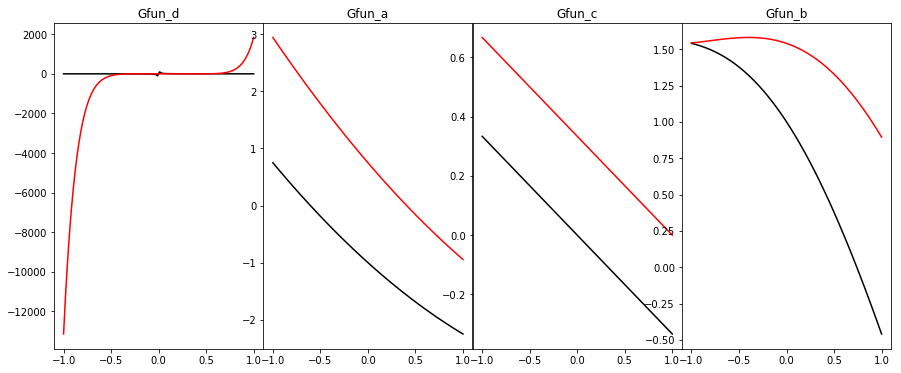

In [12]:
n = 10    # number of nodes to interpolate (uses linearly spaced x's for evaluations of f(x))
m = 100   # number of datapoints to plot in display plot.

# test functions:

# use: 
#    Gfun_a = test_functions['Gfun_a']
#    f = Ffun(Gfun_a)

fixed_point_functions = {

    'Gfun_a' : lambda x: (x**2)/4 -x/2 -1,
    'Gfun_b' : lambda x: np.cos(x),
    'Gfun_c' : lambda x: (x/3 +x)/2,
    'Gfun_d' : lambda x: np.cosh(x)/x -np.arctan(x)
}

testing_fixed_point_newton_interp(fixed_point_functions, n, m)

In [ ]:
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
# let's manipulate the example to serve our purposes

# plotly allows us to create JS graph elements, like a scatter object
plotly.offline.iplot({
    'data':[
        Scatter(x=df_imputed.SibSp.values+np.random.rand(*df_imputed.SibSp.shape)/2,
                y=df_imputed.Age,
      
                text=df_imputed.Survived.values.astype(str),
                marker=Marker(size=df_imputed.Fare, sizemode='area', sizeref=1,),
                mode='markers')
            ],
    'layout': Layout(xaxis=XAxis(title='Sibling and Spouses'), 
                     yaxis=YAxis(title='Age'),
                     title='Age and Family Size (Marker Size==Fare)')
}, show_link=False)